In [3]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import glob
import matplotlib.pyplot as plt

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [8]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [10]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

In [11]:
ticker = "SPY"
etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]

etf_df

,date,variable,value,fred,cluster,etf,fs
0,2004-01-31,DTCOLNVHFNM(t-1),1,DTCOLNVHFNM,15.0,SPY,lasso
1,2004-01-31,PPICMM(t-1),1,PPICMM,14.0,SPY,lasso
2,2004-01-31,NONBORRES(t-1),1,NONBORRES,10.0,SPY,lasso
3,2004-01-31,UEMP5TO14(t-1),1,UEMP5TO14,16.0,SPY,lasso
4,2004-01-31,AAA(t-1),1,AAA,0.0,SPY,lasso
...,...,...,...,...,...,...,...
5,2022-11-30,CUSR0000SAS(t-1),1,CUSR0000SAS,18.0,SPY,var-lingam
0,2022-12-31,SPY(t-1),1,SPY,NaN,SPY,var-lingam
1,2022-12-31,CLF16OV(t-1),1,CLF16OV,7.0,SPY,var-lingam
2,2022-12-31,AMDMUOx(t-1),1,AMDMUOx,17.0,SPY,var-lingam


In [27]:
ticker = "SPY"
etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]

sets_over_time = []
for date in etf_df["date"].unique():
    s = set(list(etf_df["cluster"].dropna().unique()))
    tmp_df = pd.DataFrame([{"date": date, "tot": s}])

    sets_over_time.append(tmp_df)
tot_df = pd.concat(sets_over_time)

individual = []
for fs in etf_df["fs"].unique():
    fs_etf_df = etf_df[etf_df["fs"] == fs]

    sets_over_time = []
    for date in fs_etf_df["date"].unique():
        s = set(list(fs_etf_df[fs_etf_df["date"] == date].dropna()["cluster"].unique()))
        tmp_set_df = pd.DataFrame([{"date": date, "set": s}])

        sets_over_time.append(tmp_set_df)
    tmp_individual_df = pd.concat(sets_over_time)
    tmp_individual_df["fs"] = fs
    
    individual.append(tmp_individual_df)
individual_df = pd.concat(individual).reset_index(drop=True)

individual_tot_df = pd.merge(individual_df, tot_df, on="date")[["date", "fs", "set", "tot"]].reset_index(drop=True)
for idx, row in individual_tot_df.iterrows():
    if len(row["set"]) == 0:
            stability = 0
    else:
        stability = len(row["set"])
    individual_tot_df.loc[idx, "stability"] = stability

In [38]:
subset_df = individual_tot_df.set_index("date").loc["2010-01-01":"2011-01-01"].reset_index()

subset_df.loc[(individual_tot_df["fs"] == "lasso")]

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_96518/3517922739.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  subset_df = individual_tot_df.set_index("date").loc["2010-01-01":"2011-01-01"].reset_index()


,date,fs,set,tot,stability
0,2010-01-31,lasso,"{0.0, 3.0, 6.0, 9.0, 10.0, 11.0, 13.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.368421
3,2010-01-31,var-lingam,"{4.0, 7.0, 8.0, 12.0, 15.0, 17.0, 18.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.368421
6,2010-02-28,pairwise-granger,"{8.0, 0.0, 5.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.157895
9,2010-03-31,multivariate-granger,"{0.0, 3.0, 13.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.157895
12,2010-04-30,lasso,"{0.0, 3.0, 6.0, 9.0, 10.0, 13.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.315789
15,2010-04-30,var-lingam,"{4.0, 7.0, 8.0, 12.0, 15.0, 18.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.315789
18,2010-05-31,pairwise-granger,"{8.0, 0.0, 5.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.157895
21,2010-06-30,multivariate-granger,"{0.0, 3.0, 13.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.157895
24,2010-07-31,lasso,"{0.0, 3.0, 6.0, 9.0, 10.0, 11.0, 13.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.368421
27,2010-07-31,var-lingam,"{4.0, 7.0, 8.0, 12.0, 14.0, 15.0, 17.0, 18.0}","{0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0.421053


In [20]:
individual_tot_df.groupby(["fs"])[["stability"]].mean().sort_values("stability", ascending=False)

,stability
fs,
lasso,0.387515
var-lingam,0.351570
pairwise-granger,0.160217
multivariate-granger,0.159532


In [28]:
individual_tot_df.groupby(["fs"])[["stability"]].mean().sort_values("stability", ascending=False)

,stability
fs,
lasso,0.387515
var-lingam,0.351570
pairwise-granger,0.160217
multivariate-granger,0.159532


<Axes: xlabel='date'>

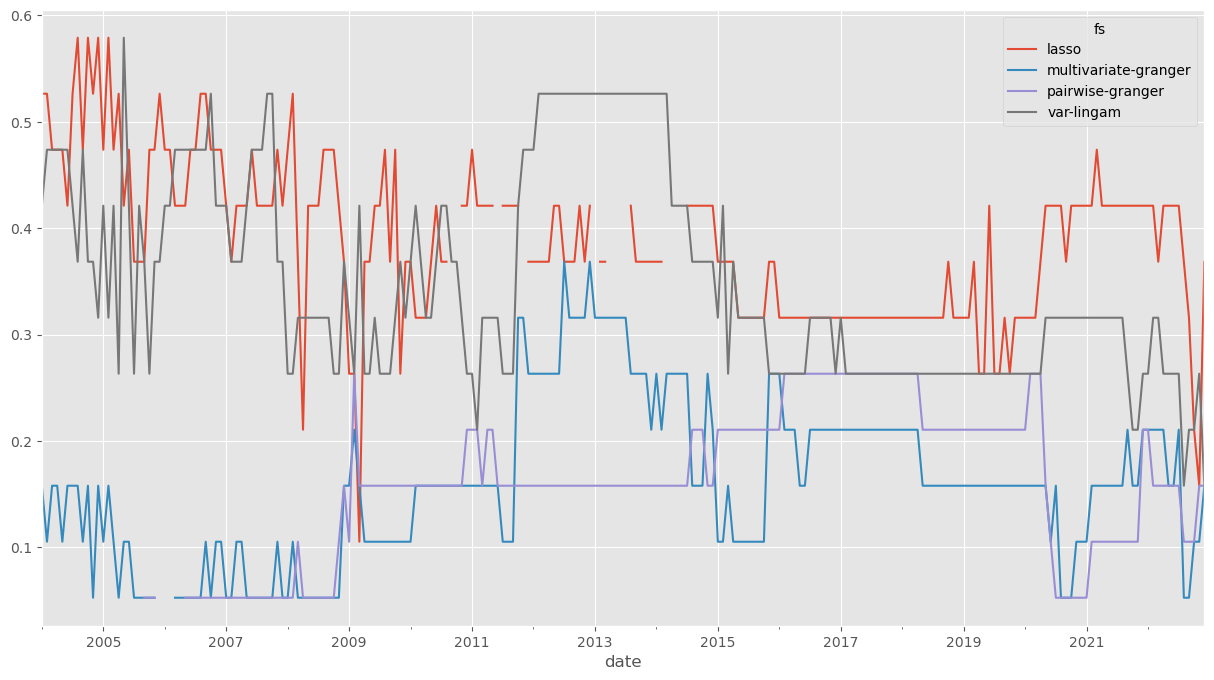

In [13]:
individual_tot_df.pivot_table(index="date", columns="fs", values="stability").plot(figsize=(15, 8))